In [1]:
from keras.layers import Convolution2D, MaxPooling2D, Activation
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.utils.vis_utils import plot_model
from keras.applications import inception_v3
from keras.applications import vgg16
from keras.applications import vgg19
from keras.applications.imagenet_utils import preprocess_input

import numpy as np
import matplotlib.pyplot as plt
import cv2  # only used for loading the image, you can use anything that returns the image as a np.ndarray

import keras_lenet

%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is disabled, cuDNN 5110)


## Lets see the cat!

(28L, 28L, 3L) 28 28 3


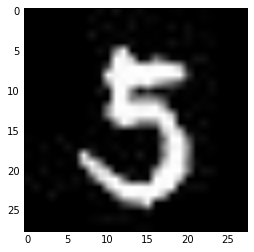

In [2]:
ori_img = cv2.imread(r'C:\DL\image\5.824.jpg')
plt.imshow(ori_img)
# what does the image look like?
print ori_img.shape, ori_img.shape[0], ori_img.shape[1], ori_img.shape[2]

(28L, 28L)


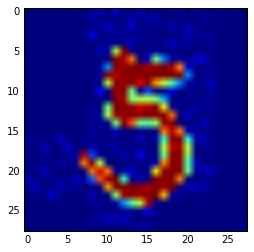

In [5]:
img_gray = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)  
plt.imshow(img_gray)
print img_gray.shape

(28L, 28L)


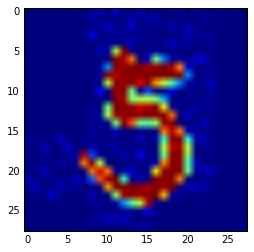

In [6]:
img_gray = np.dot(ori_img[...,:3], [0.299, 0.587, 0.114])
plt.imshow(img_gray)
print img_gray.shape

In [7]:
img = np.expand_dims(img_gray, axis=-1)
print img.shape, img.shape[0], img.shape[1], img.shape[2]

(28L, 28L, 1L) 28 28 1


In [8]:
def adjust_shape_to_show(img) :
    if K.image_data_format() == 'channels_first':
        img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
    print "adjust_shape_to_show ->", K.image_data_format(), img.shape
    return img

In [9]:
def adjust_shape_to_model(img) :
    if K.image_data_format() == 'channels_first':
        img = img.reshape(img.shape[2], img.shape[0], img.shape[1])
    print "adjust_shape_to_model ->", K.image_data_format(), img.shape
    return img

In [10]:
def pre_process(input) :
    img = adjust_shape_to_model(input)
    # Keras expects batches of images, so we have to add a dimension to trick it into being nice
    input_batch = np.expand_dims(img, axis=0)
    print "input_batch.shape", input_batch.shape
    return input_batch

In [11]:
# here we get rid of that added dimension and plot the image
def post_process(output_batch) :
    print "output_batch.shape", output_batch.shape
    output = np.squeeze(output_batch, axis=0)
    img = adjust_shape_to_show(output)
    print "img.shape", img.shape
    return img

## Load the existed models

In [12]:
# model = vgg16.VGG16(weights='imagenet', include_top=True)
model = keras_lenet.LeNet5(include_top=True)
# plot_model(model, to_file='model.png', show_shapes=True)
print model.summary()

>> LeNet5 MODEL
.\model\lenet_weights_th_dim_ordering_th_kernels.h5 True
theano
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 28, 28)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 14, 14)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 10, 10)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 5, 5)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 1, 1)         48120     
______________________________________________________________

In [52]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
model_input = model.input
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_name = "conv2d_1"
assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
layer_output = layer_dict[layer_name].output

In [53]:
input_batch = pre_process(img)

adjust_shape_to_model -> channels_first (1L, 28L, 28L)
input_batch.shape (1L, 1L, 28L, 28L)


In [54]:
output_category = model.predict(input_batch)
print "output_category.shape", output_category.shape
print output_category.argmax(), output_category.argmax(axis=-1)

output_category.shape (1L, 10L)
5 [5]


In [55]:
intermediate_layer_model = Model(inputs=model.input, outputs=layer_output)
output_batch = intermediate_layer_model.predict(input_batch)
print "output_batch.shape", output_batch.shape

output_batch.shape (1L, 6L, 28L, 28L)


In [36]:
get_layer_output = K.function([model_input], [layer_output])
output_batch = get_layer_output([input_batch])[0]
print "output_batch.shape", output_batch.shape

output_batch.shape (1L, 16L, 10L, 10L)


In [56]:
img_features = post_process(output_batch)

output_batch.shape (1L, 6L, 28L, 28L)
adjust_shape_to_show -> channels_first (28L, 28L, 6L)
img.shape (28L, 28L, 6L)


In [57]:
import math
def visualize(img_features) :
    print "img_features.shape", img_features.shape
    subplots = img_features.shape[2]
    columns = 6
    rows = min(16, int(math.ceil(float(subplots)/float(columns))))
    print subplots, rows, columns
    for i in range(min(rows*columns, subplots)) :
        img = img_features[:, :, i]
        plt.subplot(rows, columns, i+1)
        plt.imshow(img)
    plt.show()
    return

img_features.shape (28L, 28L, 6L)
6 1 6


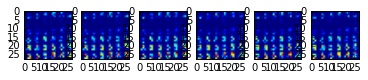

In [58]:
visualize(img_features)